# Day 4

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
import numpy as np

class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None, seed=None):
        random = np.random.default_rng(seed)
        self.W = random.normal(size=(입력수, 출력수))
        self.b = np.zeros(출력수, dtype=np.float32)
        self.활성화 = 활성화

    def __call__(self, x):
        z = x @ self.W + self.b
        if self.활성화 is not None:
            z = self.활성화(z)
        return z
    
class 신경망:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def __call__(self, x):
        """순전파"""
        for layer in self.layers:
            x = layer(x)
        return x

In [29]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def softmax(z):
    exp_z = np.exp(z - z.max(axis=1, keepdims=True)) # 양수화: exp(z) > 0
    # 양수화된 값들을 전체 합계로 나누면, 합이 1.0인 확률 분포가 됨
    return exp_z / exp_z.sum(axis=1, keepdims=True)

## 손실함수

,w,b,MSE
0,-1.000,1.000,36.279
1,1.000,0.000,1.028
2,1.003,-0.063,1.024
3,1.003,-0.063,1.024


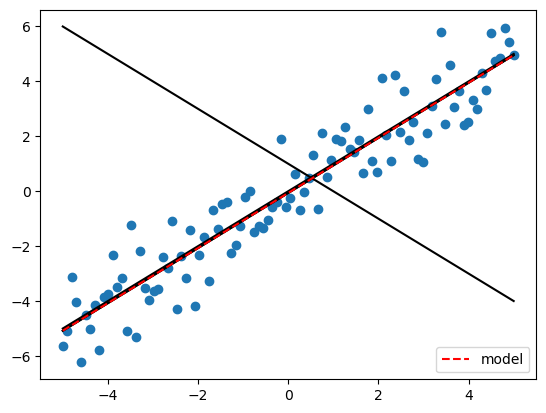

In [25]:
from sklearn.linear_model import LinearRegression

xs = np.linspace(-5, 5, 100)
noise = np.random.default_rng(seed=4).normal(0, 1, size=xs.shape)
ys = xs + noise

# 선형모형
f = lambda x, w, b: w * x + b
params = []
params.append(np.array([-1.0, 1.])) # 초기값
params.append(np.array([1.0, 0.0])) # DGP

data = xs.reshape(-1, 1); target = ys
linreg = LinearRegression().fit(data, target)
# 알고리즘의 결과
w = linreg.coef_; b = linreg.intercept_
params.append(np.append(w, b))
assert np.allclose(f(xs, w, b), linreg.predict(data))
# 정규 방정식
X = np.vstack([xs, np.ones_like(xs)]).T # 디자인 행렬
최적해 = np.linalg.inv(X.T @ X) @ X.T @ ys # 정규방정식: (X^T X)^(-1) X^T y
params.append(최적해)
assert np.allclose(최적해, np.append(w, b))

평균제곱오차 = lambda y_true, y_pred: np.mean((y_true - y_pred) ** 2)
scores = []
for w, b in params:
    y_pred = f(xs, w, b)
    scores.append(평균제곱오차(ys, y_pred))

display(pd.DataFrame(params, columns=['w', 'b']).assign(MSE=scores).round(3))

plt.scatter(xs, ys)
for w, b in params:
    plt.plot(xs, f(xs, w, b), 'k')
plt.plot(xs, linreg.predict(data), 'r--', label='model')
plt.legend()
plt.show()

## MNIST

In [ ]:
from torchvision.datasets import MNIST

mnist = {}
mnist['train'] = MNIST(root='~/data', train=True, download=True)
mnist['test'] = MNIST(root='~/data', train=False, download=True)

In [43]:
def 전처리(images):
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    X = images.astype(np.float32)
    X = X.reshape(-1, 28 * 28)
    X = X / 255.0
    return X

train_data = 전처리(mnist['train'].data)
train_target = np.array(mnist['train'].targets)
test_data = 전처리(mnist['test'].data)
test_target = np.array(mnist['test'].targets)
print(train_data.shape, test_data.shape)
assert np.isclose(train_data.max(), 1.0) and np.isclose(train_data.min(), 0.0)
assert np.isclose(test_data.max(), 1.0) and np.isclose(test_data.min(), 0.0)

(60000, 784) (10000, 784)


In [55]:
model = 신경망()
model.add(다중퍼셉트론(28*28, 50, sigmoid))
model.add(다중퍼셉트론(50, 100, sigmoid))
model.add(다중퍼셉트론(100, 10, softmax))

outputs = model(test_data)
assert np.allclose(outputs.sum(axis=1), 1.0)  # softmax(logits)
print(outputs.shape)
y_pred = np.argmax(outputs, axis=1)
print(f'정확도: {np.mean(y_pred == test_target):.2%}')

display(pd.DataFrame(outputs).assign(pred=y_pred, target=test_target)[:5].round(3))

(10000, 10)
정확도: 8.85%


,0,1,2,3,4,5,6,7,8,9,pred,target
0,0.005,0.000,0.974,0.001,0.000,0.019,0.0,0.000,0.000,0.000,2,7
1,0.005,0.000,0.053,0.000,0.077,0.782,0.0,0.082,0.001,0.000,5,2
2,0.001,0.001,0.017,0.057,0.000,0.922,0.0,0.000,0.001,0.001,5,1
3,0.011,0.000,0.464,0.001,0.031,0.492,0.0,0.001,0.000,0.000,5,0
4,0.140,0.000,0.154,0.001,0.025,0.678,0.0,0.001,0.001,0.000,5,4


## 분류 출력

### 원-핫 인코딩

다중 분류 출력은 확률 분포 형식이기 때문에 오차의 측정을 위해 정답 라벨을 확률 분포 형식으로 변환하여 비교해야 합니다.

변환은 One Hot Encoding으로 달성할 수 있습니다.

In [58]:
유형수 = len(np.unique(train_target))
원핫행렬 = np.eye(유형수)
pd.DataFrame(원핫행렬.astype(int))

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,1


In [61]:
pd.DataFrame(원핫행렬[test_target]).assign(label=test_target).head()

,0,1,2,3,4,5,6,7,8,9,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4


분류 출력은 정답과 확률 분포의 차이를 오차로써 측정합니다.

In [ ]:
outputs = model(test_data)
# 첫 번째 샘플에 대하여 예측값, 원-핫 인코딩(실제 확률 분포) 값, 오차를 비교
pd.DataFrame({
    'pred': outputs[0],
    'one-hot': 원핫행렬[test_target][0],
    'error': outputs[0] - 원핫행렬[test_target][0]
}).T.round(3)

,0,1,2,3,4,5,6,7,8,9
pred,0.005,0.0,0.974,0.001,0.0,0.019,0.0,0.0,0.0,0.0
one-hot,0.000,0.0,0.000,0.000,0.0,0.000,0.0,1.0,0.0,0.0
error,0.005,0.0,0.974,0.001,0.0,0.019,0.0,-1.0,0.0,0.0


오차제곱합과 평균제곱오차는 다릅니다. 

유형 집합의 크기 C에 대해,

$$
\text{SSE} = \frac{1}{2} \sum_{k}^{C}{\left(\hat{y}_k - y_k\right)^2}, \quad y, \hat{y} \in \mathbb{R}^{C}
$$

표본수 S에 대해, 배치 평균 오차

$$
\frac{1}{s} \sum_{i}^{s}{\text{SSE}}
$$

In [ ]:
def 오차제곱합(y_true, y_pred):
    error = y_true - y_pred
    return np.sum((error) ** 2, axis=1)

def 교차엔트로피오차(y_true, y_pred):
    delta = 1e-7
    return -np.sum(y_true * np.log(y_pred + delta), axis=1)

평균제곱오차 = np.mean(오차제곱합(원핫행렬[test_target], outputs)) # 배치 오차 (표본들의 평균)
평균교차엔트로피오차 = np.mean(교차엔트로피오차(원핫행렬[test_target], outputs))
print(pd.Series({
    'MSE': 평균제곱오차,
    'CEE': 평균교차엔트로피오차
}).round(3))

y_pred = np.argmax(outputs, axis=1)
pd.DataFrame(outputs).assign(
    SSE=오차제곱합(원핫행렬[test_target], outputs),
    CEE=교차엔트로피오차(원핫행렬[test_target], outputs),
    pred=y_pred, target=test_target).head().round(3)

MSE    1.573
CEE    7.692
dtype: float64


,0,1,2,3,4,5,6,7,8,9,SSE,CEE,pred,target
0,0.005,0.000,0.974,0.001,0.000,0.019,0.0,0.000,0.000,0.000,1.948,12.172,2,7
1,0.005,0.000,0.053,0.000,0.077,0.782,0.0,0.082,0.001,0.000,1.521,2.935,5,2
2,0.001,0.001,0.017,0.057,0.000,0.922,0.0,0.000,0.001,0.001,1.852,6.920,5,1
3,0.011,0.000,0.464,0.001,0.031,0.492,0.0,0.001,0.000,0.000,1.435,4.476,5,0
4,0.140,0.000,0.154,0.001,0.025,0.678,0.0,0.001,0.001,0.000,1.454,3.685,5,4


### 정보 엔트로피

In [96]:
엔트로피산출 = lambda 확률분포: -np.sum(확률분포 * np.log2(확률분포 + 1e-7), axis=1)

확률분포 = np.array([
    [0.5, 0.5],
    [0.3, 0.7],
    [0.1, 0.9],
    [0.01, 0.99]
])

display(pd.DataFrame(확률분포, columns=['P1', 'P2']).assign(엔트로피=엔트로피산출(확률분포)).round(3))

확률분포 = np.array([
    [1/4, 1/4, 1/4, 1/4],
    [1/2, 1/4, 1/8, 1/8]
])

display(pd.DataFrame(확률분포, columns=list('ABCD')).assign(엔트로피=엔트로피산출(확률분포)).round(3))

,P1,P2,엔트로피
0,0.50,0.50,1.000
1,0.30,0.70,0.881
2,0.10,0.90,0.469
3,0.01,0.99,0.081


,A,B,C,D,엔트로피
0,0.25,0.25,0.250,0.250,2.00
1,0.50,0.25,0.125,0.125,1.75


## 교차 엔트로피

실제 확률 분포와 예상 확률 분포의 차이값

In [101]:
실제분포 = np.array([1.0, 0.0, 0.0])
라벨 = np.argmax(실제분포)
예상분포 = np.array([
    [1/3, 1/3, 1/3],
    [0.7, 0.2, 0.1],
    [0.99, 0.01, 0.0]])

pd.DataFrame(예상분포, columns=list('ABC')).assign(CEE=교차엔트로피오차(실제분포, 예상분포)).round(3)

,A,B,C,CEE
0,0.333,0.333,0.333,1.099
1,0.700,0.200,0.100,0.357
2,0.990,0.010,0.000,0.010


## 최적화

x: -0.056, f(x): 0.003


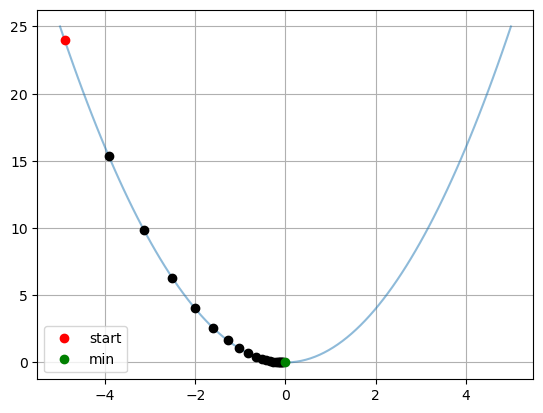

In [119]:
f = lambda x: x ** 2
dfdx = lambda x: 2 * x # 도함수

def 수치미분(f, x, h=1e-4):
    return (f(x + h) - f(x - h)) / (2 * h)

xs = np.linspace(-5, 5, 100)

plt.plot(xs, f(xs), alpha=0.5)
x = -4.9
plt.plot(x, f(x), 'ro', label='start')
# 경사 하강
학습률 = 0.1; 학습횟수 = 20
for _ in range(학습횟수):
    # x -= dfdx(x) * 학습률
    x -= 수치미분(f, x) * 학습률
    plt.plot(x, f(x), 'ko')
print(f'x: {x:.3f}, f(x): {f(x):.3f}')
plt.plot(0, f(0), 'go', label='min')
plt.legend()
plt.grid()
plt.show()

## 신경망 학습 알고리즘

In [120]:
import numpy as np
import time

sigmoid = lambda z: 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - z.max()) # 오버플로 방지
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def 경사산출(f, x):
    h = 1e-4
    경사 = np.empty_like(x)
    
    for i, xi in enumerate(x):
        x[i] = xi + h
        fxh1 = f(x)
        x[i] = xi - h
        fxh2 = f(x)
        
        경사[i] = (fxh1 - fxh2) / (2 * h)
        x[i] = xi # 원래 값 복원

    return 경사

def 경사산출_2d(f, X):
    경사 = np.zeros_like(X)
    
    for j, xj in enumerate(X):
        경사[j] = 경사산출(f, xj)
    return 경사

def 교차엔트로피오차(y, y_pred):
    delta = 1e-7
    배치크기 = y.shape[0]
    return -np.sum(y * np.log(y_pred + delta)) / 배치크기

class 다중퍼셉트론:
    def __init__(self, 입력수, 출력수, 활성화=None, seed=None):
        random = np.random.default_rng(seed)
        self.W = random.normal(size=(입력수, 출력수))
        self.b = np.zeros(shape=(출력수,))
        self.활성화 = 활성화

    def __call__(self, X):
        Z = X @ self.W + self.b # 교재 식[3.9]
        if self.활성화 is not None:
            return self.활성화(Z)
        return Z

class 신경망:
    def __init__(self, 손실함수):
        self.layers = []
        self.loss_func = 손실함수
        
    def add(self, layer):
        self.layers.append(layer)
        
    def __call__(self, X):
        for layer in self.layers:
            X = layer(X)
        return X
    
    def 손실산출(self, X, y):
        y_pred = self(X)
        손실 = self.loss_func(y, y_pred)
        return 손실
    
    def fit(self, X, y, 배치크기, 학습횟수, 학습률):
        """학습"""
        표본수 = X.shape[0]
        손실변화 = []
        for i in range(학습횟수):            
            print(f'학습 {i+1}/{학습횟수}')
            start_time = time.time()
            # 1. 미니배치
            배치색인 = np.random.choice(표본수, 배치크기)
            X_batch = X[배치색인]
            y_batch = y[배치색인]
            # 2. 경사 산출        
            f = lambda 매개변수: self.손실산출(X_batch, y_batch)
            층별경사 = []
            for layer in self.layers:
                dW = 경사산출_2d(f, layer.W)
                db = 경사산출(f, layer.b)
                층별경사.append((dW, db))
            # 3. 매개변수 갱신 (경사 하강)
            for layer, (dW, db) in zip(self.layers, 층별경사):
                layer.W -= dW * 학습률
                layer.b -= db * 학습률
            end_time = time.time()
            # (선택적) 손실확인
            손실 = self.손실산출(X_batch, y_batch)
            손실변화.append(손실)
            print(f'\t손실: {손실:.3f}, \t시간: {end_time - start_time:.1f}초')
        return 손실변화

In [121]:
from torchvision.datasets import MNIST

mnist = {}
mnist['train'] = MNIST(root='~/data', train=True, download=True)
mnist['test'] = MNIST(root='~/data', train=False, download=True)

In [122]:
def 전처리(images):
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    X = images.astype(np.float32)
    X = X.reshape(-1, 28 * 28)
    X = X / 255.0
    return X

train_data = 전처리(mnist['train'].data)
train_target = np.array(mnist['train'].targets)
test_data = 전처리(mnist['test'].data)
test_target = np.array(mnist['test'].targets)
print(train_data.shape, test_data.shape)
assert np.isclose(train_data.max(), 1.0) and np.isclose(train_data.min(), 0.0)
assert np.isclose(test_data.max(), 1.0) and np.isclose(test_data.min(), 0.0)

(60000, 784) (10000, 784)


In [126]:
model = 신경망(손실함수=교차엔트로피오차)
model.add(다중퍼셉트론(28*28, 50, sigmoid))
model.add(다중퍼셉트론(50, 100, sigmoid))
model.add(다중퍼셉트론(100, 10, softmax))

원핫행렬 = np.eye(10)
손실변화 = model.fit(train_data, 원핫행렬[train_target], 배치크기=100, 학습횟수=4, 학습률=0.1)

학습 1/4
	손실: 14.398, 	시간: 30.8초
학습 2/4
	손실: 14.064, 	시간: 33.7초
학습 3/4
	손실: 14.334, 	시간: 33.9초
학습 4/4
	손실: 12.675, 	시간: 34.1초


In [127]:
outputs = model(test_data)
y_pred = np.argmax(outputs, axis=1)
print(f'정확도: {np.mean(y_pred == test_target):.2%}')

정확도: 10.27%


## 1986 오차 역전파

In [144]:
class 더하기:
    def __call__(self, x, y):
        return x + y
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy
    
class 곱하기:
    def __init__(self):
        self.x = None
        self.y = None

    def __call__(self, x, y):
        self.x = x
        self.y = y
        return x * y
    
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy
    
합 = 더하기()
곱 = [곱하기() for _ in range(3)]

사과단가, 사과수량 = 100, 2
귤단가, 귤수량 = 150, 3
부가세 = 1.1 # 10%

print('# 순전파')
사과가격 = 곱[0](사과단가, 사과수량)
귤가격 = 곱[1](귤단가, 귤수량)
세전가격 = 합(사과가격, 귤가격)
세후가격 = 곱[2](세전가격, 부가세)
print(f'세전가격: {세전가격} x 부가세(10%) = 세후가격: {세후가격:.1f}')

print('# 역전파')
dx, dy = 곱[2].backward(1.0)
dx, dy = 합.backward(dx)
d귤단가, d귤수량 = 곱[1].backward(dx)
d사과단가, d사과수량 = 곱[0].backward(dx)

display(pd.DataFrame([{
    'd가격/d사과단가': d사과단가,
    'd가격/d사과수량': d사과수량,
    'd가격/d귤단가': d귤단가,
    'd가격/d귤수량': d귤수량
}], index=['역전파']).round(3))

# 순전파
세전가격: 650 x 부가세(10%) = 세후가격: 715.0
# 역전파


,d가격/d사과단가,d가격/d사과수량,d가격/d귤단가,d가격/d귤수량
역전파,2.2,110.0,3.3,165.0
